# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [17]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

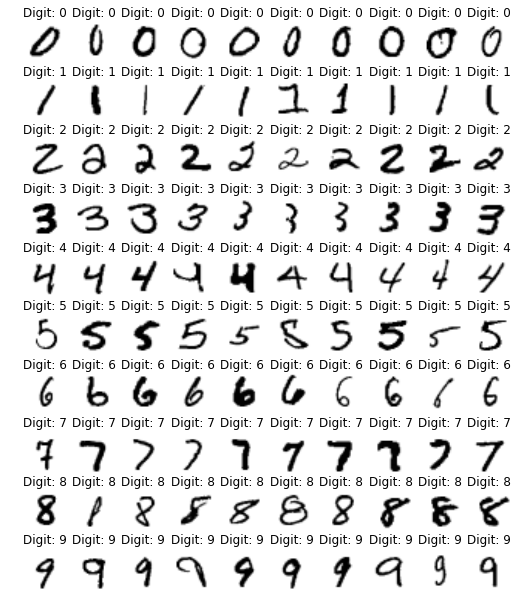

In [18]:
def P1(num_examples=10):

### STUDENT START ###
    # for each digit get the label index and use the index to get the image from dev_data
    digit_sampels = [dev_data[np.where(dev_labels == i)[0][:num_examples]] for i in range(10)]
    
    #setup plot table
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    
    #enumerate the digit samples 
    for digit, image_arr in enumerate(digit_sampels):
        for index ,image in enumerate(image_arr):
            # plot the image at index (digit * num_examples + index + 1)
            plt.subplot(10,num_examples, digit * num_examples + index + 1)
            plt.axis('off')
            #render image
            plt.imshow(image.reshape(28,28), cmap=plt.cm.gray_r)
            plt.title('Digit: %i' % digit)
    
    plt.show()
### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [31]:
def P2(k_values):

    # data structure to store results
    results = {}
### STUDENT START ###

    # for each valu of k run K-Nearest-Neighbor algorithm
    for k in k_values:
        results[k] = KNeighborsClassifier(n_neighbors=k)
        results[k].fit(mini_train_data, mini_train_labels)
        predicted_labels = results[k].predict(dev_data)
        print("Accuracy of %d-Nearest-Neighbors : %f" %(k,np.mean(dev_labels == predicted_labels)))
    
    # print precision , recall and f1 score for each digit
    labels = ['digit 0','digit 1','digit 2','digit 3','digit 4','digit 5','digit 6','digit 7','digit 8','digit 9']
    print(classification_report(dev_labels, results[1].predict(dev_data), target_names = labels))
    
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

Accuracy of 1-Nearest-Neighbors : 0.892000
Accuracy of 3-Nearest-Neighbors : 0.876000
Accuracy of 5-Nearest-Neighbors : 0.867000
Accuracy of 7-Nearest-Neighbors : 0.871000
Accuracy of 9-Nearest-Neighbors : 0.860000
             precision    recall  f1-score   support

    digit 0       0.93      0.97      0.95        91
    digit 1       0.90      0.98      0.94       133
    digit 2       0.94      0.91      0.93       111
    digit 3       0.85      0.90      0.88        98
    digit 4       0.92      0.87      0.89       107
    digit 5       0.83      0.76      0.79        78
    digit 6       0.94      0.93      0.94       101
    digit 7       0.91      0.92      0.91        98
    digit 8       0.93      0.79      0.86        97
    digit 9       0.75      0.83      0.78        86

avg / total       0.89      0.89      0.89      1000



ANSWER: 9 is the most difficult digit to predict since it has the lowest precision and F1 score

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [40]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    ## initialize classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    for index, size in enumerate(train_sizes):
        # create train and label data for given size
        temp_train_data = train_data[:size]
        temp_train_labels = train_labels[:size]
        
        #star timer
        start_time = time.time()
        knn.fit(temp_train_data, temp_train_labels)
        predicted_labels = knn.predict(dev_data)
        #stop timer
        stop_time = time.time()
        
        accuracies.append(np.mean(dev_labels == predicted_labels))
        elapsed_time = stop_time - start_time
        
        #print accuracy and elapsed time results
        print("Accuracy with training size %d : %f" % (size,accuracies[index]))
        print("Time to training for data size %d : %f sec" % (size, elapsed_time))

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Accuracy with training size 100 : 0.704000
Time to training for data size 100 : 0.100797 sec
Accuracy with training size 200 : 0.791000
Time to training for data size 200 : 0.205017 sec
Accuracy with training size 400 : 0.849000
Time to training for data size 400 : 0.412685 sec
Accuracy with training size 800 : 0.870000
Time to training for data size 800 : 0.845479 sec
Accuracy with training size 1600 : 0.902000
Time to training for data size 1600 : 1.728274 sec
Accuracy with training size 3200 : 0.931000
Time to training for data size 3200 : 3.491450 sec
Accuracy with training size 6400 : 0.941000
Time to training for data size 6400 : 7.084885 sec
Accuracy with training size 12800 : 0.954000
Time to training for data size 12800 : 14.487922 sec
Accuracy with training size 25000 : 0.964000
Time to training for data size 25000 : 29.494463 sec


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [110]:
from math import log
def P4():

### STUDENT START ###
    x_train = np.array(train_sizes)[:, np.newaxis]
    y_train = np.array(accuracies)
    
    regr = LinearRegression()
    regr.fit(x_train, y_train)
    

### STUDENT END ###

P4()

ANSWER:

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Confusion Matrix
[[ 91   0   0   0   0   0   0   0   0   0]
 [  0 132   1   0   0   0   0   0   0   0]
 [  1   0 109   1   0   0   0   0   0   0]
 [  0   0   0  95   0   1   0   1   1   0]
 [  0   0   0   0 103   0   0   0   0   4]
 [  0   0   0   0   1  76   0   0   0   1]
 [  0   2   0   0   0   0  99   0   0   0]
 [  0   1   0   0   0   0   0  97   0   0]
 [  0   2   0   1   1   3   1   0  89   0]
 [  1   1   0   0   1   0   0   1   0  82]]
Normalized Confusion Matrix
[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.992  0.008  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.009  0.     0.982  0.009  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.969  0.     0.01   0.     0.01   0.01   0.   ]
 [ 0.     0.     0.     0.     0.963  0.     0.     0.     0.     0.037]
 [ 0.     0.     0.     0.     0.013  0.974  0.     0.     0.     0.013]
 [ 0.     0.02   0.     0.     0.     0.     0.98   0.     0.     0.   ]
 [ 0.     0.0

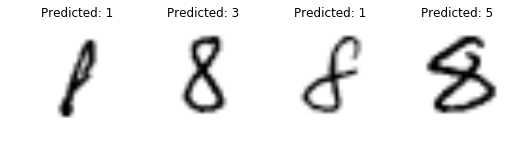

In [51]:
def P5():

### STUDENT START ###
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_data, train_labels)
    predicted_labels = knn.predict(dev_data)
    
    cm = confusion_matrix(dev_labels, predicted_labels)
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print("Confusion Matrix")
    print(cm)
    print("Normalized Confusion Matrix")
    print(np.around(cm_norm,3))
    
    error_ratios = [ row[index] for index, row in enumerate(cm_norm)]
    confused_digit = np.argmin(error_ratios)
    print("From the confusion matrix Digit %d seems to be the most difficult to predict correctly " , confused_digit)
    
    # get images of the confised digit which were incorrectly identified
    
    misidentified_images = [element for element in np.where(predicted_labels != confused_digit)[0] if element in np.where(dev_labels == confused_digit)[0] ]
    digit_sampels = dev_data[misidentified_images][:4]
    
    print("Samples of misclassified images")
    #setup plot table
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    
    for index, image in enumerate(digit_sampels):
        plt.subplot(1,4, index + 1)
        plt.axis('off')
        plt.imshow(image.reshape(28,28), cmap=plt.cm.gray_r)
        plt.title('Predicted: %i' % predicted_labels[misidentified_images[index]])
    plt.show()
    
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [81]:

#https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
def padwithtens(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 0
    vector[-pad_width[1]:] = 0
    return vector

def get_matrixblocks(image, block):
   
    bx, by = block
    imx, imy = image.shape
    temp = []
    for j in range(0, imy):
        for i in range(0, imx):
            if (i+bx <= imx) and (j+by <= imy):
                temp.append(image[i:i+bx, j:j+by].T.reshape(bx*by))
            else:
                break
    return np.asarray(temp)

def preprocess(data):
    
    processed_data = []
    for index, image in enumerate(data):
        temp_img = image.reshape(28,28).copy()
        img_padded = np.lib.pad(temp_img,1,padwithtens )
        avg_row = get_matrixblocks(img_padded,(3,3))
        
        for y in range(temp_img.shape[1]):
            for x in range(temp_img.shape[0]):
                temp_img[x,y]= sum(avg_row[y*28 + x])/9.0
        
        processed_data.append(temp_img.flatten().T)
        
    return processed_data
        
def P6():
    
### STUDENT START ###
    processed_train_data = preprocess(train_data)
    processed_dev_data = preprocess(dev_data)
    
    knn = KNeighborsClassifier(n_neighbors=1)

    #preprocess the training data but not the dev data
    knn.fit(processed_train_data, train_labels)
    predicted_labels = knn.predict(dev_data)
    print("Accuracy when preprocess the training data but not the dev data : ", np.mean(predicted_labels == dev_labels))
    
    #preprocess the dev data but not the training data
    knn.fit(train_data, train_labels)
    predicted_labels = knn.predict(processed_dev_data)
    print("Accuracy when preprocess the dev data but not the training data : ", np.mean(predicted_labels == dev_labels))
    
    #preprocess both training and dev data
    knn.fit(processed_train_data, train_labels)
    predicted_labels = knn.predict(processed_dev_data)
    print("Accuracy when preprocess both training and dev data : ", np.mean(predicted_labels == dev_labels))
    
### STUDENT END ###

P6()

Accuracy when preprocess the training data but not the dev data :  0.984
Accuracy when preprocess the dev data but not the training data :  0.966
Accuracy when preprocess both training and dev data :  0.983


ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [102]:
# binarize pixels
def binarize(image):
    temp_data = image.copy()
    temp_data[temp_data > 0] = 1
    return temp_data

def multi_level(image):
    temp_data = image.copy()
    temp_data[temp_data >= 0.5 ] = 2
    temp_data[np.bitwise_and(temp_data > 0 , temp_data < 0.5) ] = 1
    return temp_data


def P7():

### STUDENT START ###
    binary_train_data = [binarize(image) for image in train_data]
    binary_dev_data = [binarize(image) for image in dev_data]

    bnb = BernoulliNB(alpha=1, fit_prior= False)
    bnb.fit(binary_train_data, train_labels)
    
    print('BernoulliNB accuracy: ', bnb.score(binary_dev_data, dev_labels))

    trilevel_train_data = [multi_level(image) for image in train_data]
    trilevel_dev_data = [multi_level(image) for image in dev_data]
    
    mnb = MultinomialNB(alpha=1, fit_prior= False)
    mnb.fit(trilevel_train_data, train_labels)
    
    print('MultinomialNB accuracy: ', mnb.score(trilevel_dev_data, dev_labels))
### STUDENT END ###

P7()

BernoulliNB accuracy:  0.837
MultinomialNB accuracy:  0.816


ANSWER: Multi-class version shows a slight decrease in aacuracy. It doent help imporve accuracy probably because it has the opposite effect of smoothening.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [103]:
def P8(alphas):

### STUDENT START ###camera

    binary_train_data = [binarize(image) for image in train_data]
    binary_dev_data = [binarize(image) for image in dev_data]
    gsnb = GridSearchCV(BernoulliNB(), alphas)
    gsnb.fit(binary_train_data, train_labels)
    
    print('The best alpha is : ', gsnb.best_params_['alpha'])
    
    bnb = BernoulliNB(alpha=0.0, fit_prior= False)
    bnb.fit(binary_train_data, train_labels)
    
    print('BernoulliNB accuracy when aplha is 0.0: ', bnb.score(binary_dev_data, dev_labels))
    
    return gsnb

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)



C:\Program Files\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:766: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:766: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:766: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)


The best alpha is :  0.0001
BernoulliNB accuracy when aplha is 0.0:  0.091


C:\Program Files\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:766: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)


In [105]:
print(nb.best_params_)

{'alpha': 0.0001}


ANSWER:

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [106]:
def P9():

### STUDENT END ###
    gnb = GaussianNB()
    gnb.fit(train_data, train_labels)
    score = gnb.score(dev_data, dev_labels)
    print('GaussianNB accuracy: ',score)
    
    index = np.array([126,127,128,129,151,152,153,154,155,156,157,158,159,178,179,180,181,182,183,184,185,186,187,188,205,206,207,208,209,210,211,212,213,214,215,216,217,232,233,234,235,236,237,238,239,240,241,242,243,244,245,260,261,262,263,264,265,266,267,268,269,270,271,272,273,288,289,290,291,292,293,294,295,296,297,298,299,300,301,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,595,596,597,598,599,600,601,602,603,604,605,606,607,623,624,625,626,627,628,629,630,631,632,633,634,652,653,654,655,656,657,658,659,660,661,683,684,685,686])
    trim_train_data = [np.take(train_data[i],index) for i in range(train_data.shape[0])]
    trim_dev_data = [np.take(dev_data[i],index) for i in range(dev_data.shape[0])]
    
    
    gnb.fit(trim_train_data, train_labels)
    score = gnb.score(trim_dev_data, dev_labels)
    print('Imporved GaussianNB accuracy: ',score)
    
    
    binary_train_data = [binarize(image) for image in train_data]
    binary_dev_data = [binarize(image) for image in dev_data]
    
    bnb = BernoulliNB(alpha=0.0001, fit_prior= False)
    bnb.fit(binary_train_data, train_labels)
    
    print('BernoulliNB accuracy: ', bnb.score(binary_dev_data, dev_labels))

### STUDENT END ###

gnb = P9()

GaussianNB accuracy:  0.569
Imporved GaussianNB accuracy:  0.832
BernoulliNB accuracy:  0.838


ANSWER: GaussianNB doesnt work well with sparse features. So in order to remove sparse features I calculated the variance of each feature vector and excluded features with variance less than 0.1. This left me with approximately 250 features form the original set of 784. 
Feature vector with higher variance is more likely to be dense.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

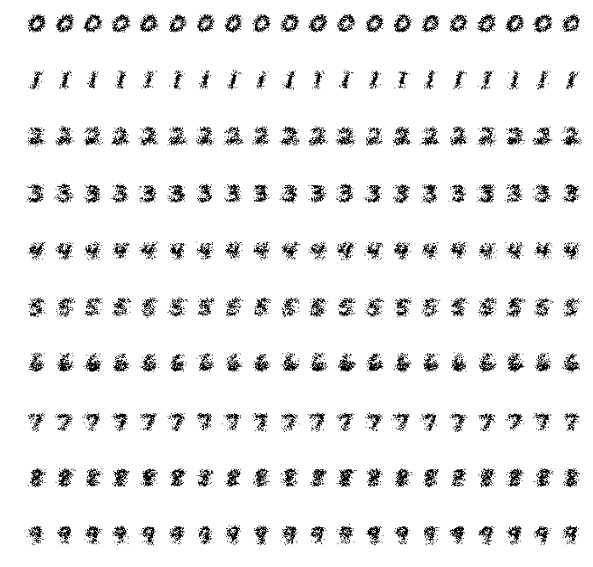

In [108]:
def P10(num_examples):

### STUDENT START ###
    binary_train_data = [binarize(image) for image in train_data]
    binary_dev_data = [binarize(image) for image in dev_data]
    
    bnb = BernoulliNB(alpha=0.0001, fit_prior= False)
    bnb.fit(binary_train_data, train_labels) 
    
    plt.figure(figsize=(10,10))
    plt.axis('off')
    #plt.imshow(temp_img,cmap=plt.cm.gray_r, interpolation='nearest')
    for i in range(10):
        probs = np.exp(bnb.feature_log_prob_)[i]
        
        for j in range(num_examples):
            image = np.array([np.random.binomial(1, p, 1)[0] for p in probs]).reshape(28,28)
            plt.subplot(10, num_examples, i * num_examples + j + 1 )
            plt.axis('off')
            plt.imshow(image,cmap=plt.cm.gray_r)
    
    plt.show()    
        
### STUDENT END ###

P10(20)


ANSWER:The generated digits resemble the actual digits, but since there are generated using probability distribution of each pixel, the all look similar with very little variability in shape and size, unlike the training samples

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [109]:
def P11(buckets, correct, total):
    
### STUDENT START ###

    binary_train_data = [binarize(image) for image in train_data]
    binary_dev_data = [binarize(image) for image in dev_data]
    
    bnb = BernoulliNB(alpha=0.0001, fit_prior= False)
    bnb.fit(binary_train_data, train_labels) 
    
    probs = bnb.predict_proba(binary_dev_data)
    predicted_labels = bnb.predict(binary_dev_data)
    
    for index, label in enumerate(dev_labels):
        max_prob = probs[index].max()
        b_pos = np.where(max_prob <= buckets)[0][0]
        
        total[b_pos] += 1
        correct[b_pos] += label == predicted_labels[index]
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total =   2    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  25    accuracy = 0.280
p(pred) <= 0.9990000000000    total =  72    accuracy = 0.472
p(pred) <= 0.9999900000000    total =  52    accuracy = 0.423
p(pred) <= 0.9999999000000    total =  57    accuracy = 0.737
p(pred) <= 0.9999999990000    total =  52    accuracy = 0.635
p(pred) <= 0.9999999999900    total =  53    accuracy = 0.792
p(pred) <= 0.9999999999999    total =  53    accuracy = 0.887
p(pred) <= 1.0000000000000    total = 634    accuracy = 0.964


ANSWER: The model demonstrates week calibration since its accuracy is higher when posterior is high

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()